# Data synthesis pipeline
Following the steps in this Notebook will allow you to synthesize data as .csv input.<br>
All names under chapter <b>2. Variables</b> should be checked and changed if necessary.<br>
Processing and synthesizing the data may take a while depending on the chosen dataset.<br>
Results are stored in the \Results folder of this pipeline.

## 1. Environment
Install required python package via pip (shapely, geopandas). Warnings may be ignored. If you encounter errors, try installing the packages via Anconda Prompt (from the Start menu).

In [1]:
#pip install shapely

In [2]:
#pip install synthgauge 

In [3]:
#pip install pyreadstat

In [4]:
#pip install geopandas --user

### 1.1 Restart Kernel or comment out .plot_functions
To continue with the next section, restart the kernel or comment out the line: "from Pipeline.plotting.plot_functions import map_plotter, gemeente_lader, distribution_comparison" (note that you won't be able to execute chapter 5.4). To restart the kernel, go to "Kernel" in the toolbar and select "Restart". After restart you can execute the following block.

In [5]:
# Import all the required modules. Do not change these settings.
import os
import json
import subprocess
#import Pipeline.final_score

from Pipeline.full_data_process import full_data_process
from Pipeline.df_compare import *
from Pipeline.privacy_functions import privacy_calc, privacy_calc_id
from Pipeline.final_score import final_scoring
from Pipeline.plotting.plot_functions import map_plotter, gemeente_lader, distribution_comparison
from Pipeline.data_processing.df_comparison.df_comparer import correlation_comparison
from pathlib import Path

# loads the Rscript location from the .vscode/settings.json file
with open('.vscode/settings.json') as f:
    settings = json.load(f)

rscript_loc = settings["rscript.path"]

print("Rscript path:", rscript_loc)

Rscript path: C:\Users\PinhoUlianA\AppData\Local\Programs\R\R-4.4.2\bin\x64\Rscript.exe


## 2. Variables
The following section contains the variables and configuration used for the data synthesization. You can change these accordingly, depending on where the (input) data is located and where you would like to store the output (synthethic data).

In [6]:
# The full data location of the dataset that will be used as input
full_data_location = 'input_test/fake_nutrition_nl.csv' # example dataset with real NL zip codes and skewed age distribution following the NL population
#full_data_location = 'input_test/daily_food_nutrition_with_demo.csv'
#full_data_location = 'input_test/daily_food_nutrition_with_demo - kopie.csv' # original testing file with random zip codes (not real NL)

# Columns to drop from the dataframe (default: empty)
drop_cols = []
# The name used for the synthetic files and subfolders
name = 'synth_daily_food_nutrition_dataset'
# The location where all the output such as the training dataset and synthetic dataset will be stored.
output_location = os.path.join(os.getcwd(), 'Results\\' + name)
# Y columns are the columns in the dataset for which the utility score will be calculated (default: age, gender). 
y_columns = ['age','gender']
#y_columns = ['Calories (kcal)','Meal_Type']
# ID columns are the columns in the dataset for which additional privacy scores will be calculated (default: age, gender, zip_code)
id_columns = ['age', 'gender', 'zip_code']
# Differential Privacy columns
dp_columns = ['age', 'zip_code']

# Variables used for drawing the graphs, col is the column which will be plotted for both the map and the distribution
col = 'daily_kcal' #'age'
# The name of the column containing the zip_code4 data (default: zip_code)
zip_code_column = 'zip_code'


# The location of the synthpop file
synthpop_file = os.path.join(os.getcwd(), 'R_scripts\synthpop_script.R')
# The location of the Rscript exe file
rscript_loc = "C:/Users/PinhoUlianA/AppData/Local/Programs/R/R-4.4.2/bin/Rscript.exe"

For testing only, using the daily_food_nutrition_with_demo.csv, this functions reverts the simulated zip codes to real zip codes in the Netherlands:

In [7]:
# --- Optional: broad built-in NL pool (4-digit prefixes spread across NL; not exhaustive)
# Tip: pass your own complete list via nl_prefixes or nl_prefixes_csv for 100% coverage.
NL_PREFIXES_DEFAULT = [
    # Amsterdam / Amstelland
    *[str(x) for x in range(1000, 1100)],  # 1000–1099
    "1111","1112","1113","1114","1115","1117","1118",  # Schiphol / Haarlemmermeer
    # Haarlem / IJmond
    *[str(x) for x in range(2000, 2030)], "2061","2063","2071","2082",
    # Den Haag / Delft / Westland
    *[str(x) for x in range(2500, 2600)], "2611","2612","2624","2631","2678",
    # Rotterdam / Rijnmond
    *[str(x) for x in range(3000, 3080)], "3111","3131","3141","3201","3223",
    # Utrecht / Amersfoort
    *[str(x) for x in range(3400, 3420)], *[str(x) for x in range(3500, 3600)], "3701","3811","3821",
    # ’s-Hertogenbosch / Eindhoven / Tilburg / Breda
    *[str(x) for x in range(4800, 4820)], "4901","5011","5038","5211","5611","5651",
    # Nijmegen / Arnhem
    "6511","6525","6531","6541","6811","6828","6841",
    # Zwolle / Deventer
    "7411","7423","8011","8021",
    # Groningen (stad + provincie)
    "9700","9711","9721","9731","9743","9751","9791","9931","9901","9991",
    # Friesland (Leeuwarden, Drachten, Heerenveen)
    "8911","8931","8441","8448","8449","8442","8443","8461",
    # Drenthe (Assen, Emmen)
    "9401","9402","9405","7811","7821",
    # Overijssel (Enschede, Hengelo)
    "7511","7522","7551","7607",
    # Zeeland
    "4331","4381","4461","4531","4561","4382",
    # Limburg (Maastricht, Heerlen, Venlo)
    "6211","6221","6411","6412","5911","5921",
    # Flevoland (Lelystad, Almere)
    "1311","1321","1331","1341","1351","8211","8221","8232"
]

def force_zip_pool_netherlands(
    df: pd.DataFrame,
    col: str = "zip_code",
    seed: int = 42,
    nl_prefixes: list[str] | None = None,
    nl_prefixes_csv: str | None = None,
    csv_column: str = "postcode4",
) -> pd.DataFrame:
    """
    Overwrite df[col] with randomized 4-digit Dutch postcodes (no letters).
    Keeps the column as categorical (pandas 'category').

    Priority:
      1) If nl_prefixes list is provided, sample from it.
      2) Else if nl_prefixes_csv is provided, read csv_column and use those 4-digit codes.
      3) Else use a built-in broad NL pool (not exhaustive).

    Notes:
      - Expects 4-digit strings like '1234'. If your CSV has '1234 AB', pre-clean or we will extract digits.
    """
    rng = np.random.default_rng(seed)
    n = len(df)

    # choose pool
    pool = None
    if nl_prefixes:
        pool = pd.Series(nl_prefixes, dtype="string")
    elif nl_prefixes_csv:
        try:
            pool = pd.read_csv(nl_prefixes_csv)[csv_column].astype("string")
        except Exception as e:
            print(f"[warn] Could not read '{nl_prefixes_csv}': {e}. Falling back to default NL pool.")

    if pool is not None:
        # normalize to 4-digit strings: strip spaces/letters, keep first 4 digits if present
        pool = (pool.str.extract(r"(\d{4})", expand=False)
                     .dropna()
                     .astype(str)
                     .str.zfill(4))
        pool = pool[pool.str.match(r"^\d{4}$")]
        if len(pool) == 0:
            print("[warn] Provided pool had no usable 4-digit NL codes. Falling back to default NL pool.")
            pool = pd.Series(NL_PREFIXES_DEFAULT, dtype="string")
    else:
        pool = pd.Series(NL_PREFIXES_DEFAULT, dtype="string")

    # sample and assign
    df[col] = pd.Series(rng.choice(pool.values, size=n), index=df.index)

    # ensure categorical
    df[col] = df[col].astype("category")
    return df


# df = pd.read_csv(full_data_location)

# # Option A: use built-in broad NL pool
# df = force_zip_pool_netherlands(df, col="zip_code")

# # Option B (recommended): pass a complete list or CSV of valid NL 4-digit postcodes
# # df = force_zip_pool_netherlands(df, col="zip_code", nl_prefixes=my_full_list)
# # df = force_zip_pool_netherlands(df, col="zip_code", nl_prefixes_csv="nl_postcode4.csv", csv_column="postcode4")

# df.to_csv(full_data_location, index=False)  # overwrite

## 3. Data processing
The following section performs the necessary data (pre-)processing steps. The output folders will be created, including the training and holdout datasets.

In [8]:
synth_csv_folder = Path(output_location) / f"{name}_synths"
synth_csv_folder.mkdir(parents=True, exist_ok=True)  # cria a pasta se não existir

train_csv_location   = str(Path(output_location) / f"{name}_train.csv")
holdout_csv_location = str(Path(output_location) / f"{name}_holdout.csv")
synth_csv_location   = str(synth_csv_folder / f"{name}_synthpop.csv")

In [9]:
# Create the folder of the output location (only if it does not exist yet)
if not os.path.exists(output_location):
    os.makedirs(output_location)
# Create the folder of for the synthetic datasets (only if it does not exist yet)
if not os.path.exists(synth_csv_folder):
    os.makedirs(synth_csv_folder)

In [10]:
# This function will make sure the file can be processed by synthpop
# The function will print the column types: binary, categorical and continues columns
full_data_process(file_loc=full_data_location, train_test_path=output_location, name=name, drop_cols=drop_cols)


 Amount of binary columns:  0 
 Amount of categorical columns:  1 
 Amount of continues columns:  7
Finished processing


# 4. Running Synthpop
The code below will run the R script and use synthpop to create synthetic data <br>
The script may take a while to run. <br>
<br>
Synthpop default processing method: <b>Visit order of empty columns first.</b>

In [11]:
# This script uses the provided (local) R-libraries. 
# Verify if the script accesses the correct folder containing the synthpop package.
print(synthpop_file)

c:\Users\PinhoUlianA\OneDrive - UMCG\Documenten\GitHub\my_synthetic-data-pipeline\R_scripts\synthpop_script.R


In [12]:
process = subprocess.Popen(
    [rscript_loc, synthpop_file, train_csv_location, synth_csv_location],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
)

# print the output and errors (if any)
for line in process.stdout:
    print(line, end="")

stderr = process.stderr.read()
if stderr:
    print("STDERR:\n", stderr)

process.wait()

Starting
c:\Users\PinhoUlianA\OneDrive - UMCG\Documenten\GitHub\my_synthetic-data-pipeline\Results\synth_daily_food_nutrition_dataset\synth_daily_food_nutrition_dataset_train.csv 
c:\Users\PinhoUlianA\OneDrive - UMCG\Documenten\GitHub\my_synthetic-data-pipeline\Results\synth_daily_food_nutrition_dataset\synth_daily_food_nutrition_dataset_synths\synth_daily_food_nutrition_dataset_synthpop.csv 

Variable(s): gender have been changed for synthesis from character to factor.

Synthesis
-----------
 age gender zip_code daily_kcal protein_g carbs_g fat_g fruit_portions
Arquivo salvo em: c:\Users\PinhoUlianA\OneDrive - UMCG\Documenten\GitHub\my_synthetic-data-pipeline\Results\synth_daily_food_nutrition_dataset\synth_daily_food_nutrition_dataset_synths\synth_daily_food_nutrition_dataset_synthpop.csv 
STDERR:
 Warning message:
package 'synthpop' was built under R version 4.4.3 



0

# 6. Apply differential privacy

In [13]:
# Load dataset
synthetic_data = pd.read_csv(synth_csv_location)

# Set privacy parameter and select columns to privatize
epsilon, sensitivity = 0.8, 1
columns = ['age', 'zip_code']

# Add Laplace noise to create noisy and synthetic datasets
noisy_data = synthetic_data.copy()
for column in columns:
    noisy_data[column] += np.random.laplace(0, scale=sensitivity/epsilon, size=len(synthetic_data)).round(0)

# Write the noisy datasets to CSV files
noisy_csv_location = synth_csv_folder / f"{name}_noisy.csv"
noisy_data.to_csv(noisy_csv_location, index=False)

In [14]:
# Select the column to compare
column_to_compare = 'age'

# Print basic statistics of the real and synthetic datasets
print('Real data:')
print(synthetic_data[column_to_compare].describe())
print('\nSynthetic data:')
print(noisy_data[column_to_compare].describe())

# Compute the mean absolute difference between the real and synthetic datasets
mad = np.mean(np.abs(synthetic_data[column_to_compare] - noisy_data[column_to_compare]))

print('\nMean Absolute Difference:', mad)

Real data:
count    2500.000000
mean       53.504400
std        21.118494
min        18.000000
25%        35.000000
50%        54.000000
75%        72.000000
max        89.000000
Name: age, dtype: float64

Synthetic data:
count    2500.000000
mean       53.471200
std        21.187466
min        12.000000
25%        35.000000
50%        54.000000
75%        72.000000
max        93.000000
Name: age, dtype: float64

Mean Absolute Difference: 1.1644


# 7. Apply k-anonimity

In [15]:
def custom_round(x, base=5):
    return int(base * round(float(x)/base))

# Load dataset
synthetic_data = pd.read_csv(synth_csv_location)
synthetic_data = synthetic_data.dropna(subset = ['zip_code'])

# Define the columns that contain sensitive information
sensitive_columns = id_columns

# Apply k-anonimity measures (rounding of variables)
synthetic_data['zip_code'] = synthetic_data['zip_code'].apply(lambda x: custom_round(x, base=5)).astype("float64")
synthetic_data['age'] = synthetic_data['age'].apply(lambda x: custom_round(x, base=5)).astype("float64")

# Group the data by the sensitive columns and count the number of rows in each group
group_counts = synthetic_data.groupby(sensitive_columns).size().reset_index(name='count')

# Determine the minimum group size (k) for each sensitive attribute combination
min_counts = group_counts.groupby(sensitive_columns)['count'].min().reset_index(name='min_count')

# Compute the overall minimum group size (k-anonymity level) as the minimum of all the individual k values
k_anonymity_level = min_counts['min_count'].min()

# Print the k-anonymity level
print('The dataset has a k-anonymity level of', k_anonymity_level)
print(group_counts)

# Write the k-anonymity datasets to CSV files
kanon_csv_location = synth_csv_folder / f"{name}_kanonymity.csv"
synthetic_data.to_csv(kanon_csv_location, index=False)

The dataset has a k-anonymity level of 1
      age  gender  zip_code  count
0    20.0  female    1030.0      1
1    20.0  female    1035.0      1
2    20.0  female    1045.0      4
3    20.0  female    1815.0      1
4    20.0  female    1825.0      3
..    ...     ...       ...    ...
929  90.0    male    6220.0      1
930  90.0    male    6515.0      1
931  90.0    male    8925.0      2
932  90.0    male    9720.0      1
933  90.0   other    3035.0      1

[934 rows x 4 columns]


# 5. Evaluation
The code below will evaluate the generated synthpop data against the holdout dataset using the metrics on utility, fidelity, and privacy. These outcomes can be used to evaluate the performance of synthetic data generation methods when compared to real data.<br>

<b>Utility</b>: Utility refers to the usefulness of synthetic data for a particular task or analysis. In other words, how well does the synthetic data perform when used in place of real data? A synthetic dataset with high utility should be able to provide similar or equivalent results to those obtained using real data.<br>

<b>Fidelity</b>: Fidelity refers to the degree to which the synthetic data accurately represents the real data. A synthetic dataset with high fidelity should be able to capture the key statistical properties of the real data, such as the mean, median, standard deviation, and distribution of variables.<br>

<b>Privacy</b>: Privacy refers to the level of protection provided to individuals' personal information in the synthetic dataset. A synthetic dataset with high privacy should not be susceptible to re-identification attacks, meaning that it should not be possible to link an individual's identity to their personal information in the dataset.<br>

## 5.1 Fidelity & Utility calculations


In [16]:
end_results, ratio_results, reggre, classi = df_compare(train_csv_location,
                                                        holdout_csv_location, 
                                                        synth_csv_folder,
                                                        c=1,
                                                        y_columns=y_columns,
                                                        subset=None)

Processed: ['holdout', 'synth_daily_food_nutrition_dataset_kanonymity', 'synth_daily_food_nutrition_dataset_noisy', 'synth_daily_food_nutrition_dataset_synthpop']
Starting calculations for: holdout


c:\Users\PinhoUlianA\OneDrive - UMCG\Documenten\GitHub\my_synthetic-data-pipeline\Pipeline\data_processing\result_processing.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end_result['jenson_shannon'] = jsws[0]
c:\Users\PinhoUlianA\OneDrive - UMCG\Documenten\GitHub\my_synthetic-data-pipeline\Pipeline\data_processing\result_processing.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end_result['total_variational_dist'] = jsws[1]
c:\Users\PinhoUlianA\OneDrive - UMCG\Documenten\GitHub\my_synthetic-data-pipeline\Pipeline\data_processing\result_processing.py:71: FutureWarning: Series.__getitem__ treating keys as

Finished holdout in 0.04 minutes
Starting calculations for: synth_daily_food_nutrition_dataset_kanonymity


c:\Users\PinhoUlianA\OneDrive - UMCG\Documenten\GitHub\my_synthetic-data-pipeline\Pipeline\data_processing\result_processing.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end_result['jenson_shannon'] = jsws[0]
c:\Users\PinhoUlianA\OneDrive - UMCG\Documenten\GitHub\my_synthetic-data-pipeline\Pipeline\data_processing\result_processing.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end_result['total_variational_dist'] = jsws[1]
c:\Users\PinhoUlianA\OneDrive - UMCG\Documenten\GitHub\my_synthetic-data-pipeline\Pipeline\data_processing\result_processing.py:71: FutureWarning: Series.__getitem__ treating keys as

Finished synth_daily_food_nutrition_dataset_kanonymity in 0.04 minutes
Starting calculations for: synth_daily_food_nutrition_dataset_noisy


c:\Users\PinhoUlianA\OneDrive - UMCG\Documenten\GitHub\my_synthetic-data-pipeline\Pipeline\data_processing\result_processing.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end_result['jenson_shannon'] = jsws[0]
c:\Users\PinhoUlianA\OneDrive - UMCG\Documenten\GitHub\my_synthetic-data-pipeline\Pipeline\data_processing\result_processing.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end_result['total_variational_dist'] = jsws[1]
c:\Users\PinhoUlianA\OneDrive - UMCG\Documenten\GitHub\my_synthetic-data-pipeline\Pipeline\data_processing\result_processing.py:71: FutureWarning: Series.__getitem__ treating keys as

Finished synth_daily_food_nutrition_dataset_noisy in 0.04 minutes
Starting calculations for: synth_daily_food_nutrition_dataset_synthpop


c:\Users\PinhoUlianA\OneDrive - UMCG\Documenten\GitHub\my_synthetic-data-pipeline\Pipeline\data_processing\result_processing.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end_result['jenson_shannon'] = jsws[0]
c:\Users\PinhoUlianA\OneDrive - UMCG\Documenten\GitHub\my_synthetic-data-pipeline\Pipeline\data_processing\result_processing.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  end_result['total_variational_dist'] = jsws[1]
c:\Users\PinhoUlianA\OneDrive - UMCG\Documenten\GitHub\my_synthetic-data-pipeline\Pipeline\data_processing\result_processing.py:71: FutureWarning: Series.__getitem__ treating keys as

Finished synth_daily_food_nutrition_dataset_synthpop in 0.03 minutes


### 5.1.1 Fidelity results

Fidelty evaluations compared to the real dataset.<br><br>
    <b>dupe_numbers</b>: Number of duplicate records.<br>
    <b>sum_%mean_diff</b>: This variable represents the sum of the percentage difference between the means of two sets of data. It can be used to quantify the degree of difference between the two sets of data.<br>
    <b>sum_%median_diff</b>: This variable represents the sum of the percentage difference between the medians of two sets of data. It can be used to quantify the degree of difference between the two sets of data.<br>
    <b>sum_%std_diff</b>: This variable represents the sum of the percentage difference between the standard deviations of two sets of data. It can be used to quantify the degree of difference between the two sets of data.<br>
    <b>binary_val_count_diff</b>: This variable represents the difference in the count of binary values between two sets of data. It can be used to compare the frequency of occurrence of certain binary values between two sets of data.<br>
    <b>correlation_norm</b>: This variable represents the normalized correlation between two sets of data. It can be used to measure the strength and direction of the linear relationship between the two sets of data.<br>
    <b>real_or_snyth_acc</b>: This variable represents the accuracy of a machine learning model in classifying real versus synthetic data. It can be used to evaluate the performance of the model in distinguishing between real and synthetic data.<br>
    <b>jenson_shannon</b>: This variable represents the Jensen-Shannon divergence between two probability distributions. It can be used to measure the dissimilarity between the two distributions.<br>
    <b>total_variational_dist</b>: This variable represents the total variation distance between two probability distributions. It can be used to measure the distance between the two distributions.<br>
    <b>wasserstein_dist</b>: This variable represents the Wasserstein distance between two probability distributions. It can be used to measure the distance between the two distributions, taking into account the underlying geometry of the space in which the distributions are defined.<br>

In [17]:
end_results.T

,dupe_numbers,sum_%_mean_diff,sum_%_median_diff,sum_%_std_diff,binary_val_count_diff,correlation_norm,real_or_synth_acc,jenson_shannon,total_variational_dist,wasserstein_dist
holdout,0.0,6.3,8.7,9.5,0.0,0.21,0.484,0.16862,0.13950,0.00179
synth_daily_food_nutrition_dataset_kanonymity,0.0,4.5,1.9,7.4,0.0,0.23,0.689,0.30620,0.27845,0.00406
synth_daily_food_nutrition_dataset_noisy,0.0,4.5,1.8,7.4,0.0,0.23,0.504,0.19154,0.15970,0.00148
synth_daily_food_nutrition_dataset_synthpop,1.0,4.6,1.9,8.6,0.0,0.23,0.417,0.11299,0.09080,0.00121


### 5.1.2 Fidelity ratio results
Calculated by dividing all results from a synthetic dataset by the holdout dataset. <br>

Each result (expect for dupe_numbers) should near 1.0 to compare the synthetic data to the holdout dataset. This would conclude a good statistical comparable synthetic dataset.

In [18]:
ratio_results.T

,dupe_numbers,sum_%_mean_diff,sum_%_median_diff,sum_%_std_diff,binary_val_count_diff,correlation_norm,real_or_synth_acc,jenson_shannon,total_variational_dist,wasserstein_dist
synth_daily_food_nutrition_dataset_kanonymity,NaN,0.71,0.22,0.78,NaN,1.1,1.42,1.82,2.00,2.27
synth_daily_food_nutrition_dataset_noisy,NaN,0.71,0.21,0.78,NaN,1.1,1.04,1.14,1.14,0.83
synth_daily_food_nutrition_dataset_synthpop,inf,0.73,0.22,0.91,NaN,1.1,0.86,0.67,0.65,0.68


### 5.1.3 Utility regression results
Only showing the r2 score, the other scores calculated are the mse and the max error.<br>

The r2 score (also known as the coefficient of determination) is a very important metric that is used to evaluate the performance of a regression-based machine learning model. It works by measuring the amount of variance in the predictions explained by the dataset. Simply put, it is the difference between the samples in the dataset and the predictions made by the model.<br>

If the value of the r squared score is 1, it means that the model is perfect and if its value is 0, it means that the model will perform badly on an unseen dataset. The result should be compared to the score of the holdout dataset.



In [19]:
reggre.xs('r2', level=1, drop_level=False).sort_values(by=reggre.columns[:1][0], ascending=False)

,,age
frame,,
holdout,r2,0.071
synth_daily_food_nutrition_dataset_noisy,r2,0.056
synth_daily_food_nutrition_dataset_synthpop,r2,0.051
synth_daily_food_nutrition_dataset_kanonymity,r2,0.047


### 5.1.4 Utility classification results
Only showing the accuracy, other scores calculated are the f1, recall and precision.

Accuracy is the percentage of correct classifications that a trained machine learning model achieves, i.e., the number of correct predictions divided by the total number of predictions across all classes. Accuracy of 0 means the classifier always predicts the wrong label, whereas accuracy of 1 means that it always predicts the correct label.<br>

Accuracy is an indicator for under- and overfitting and the value should be comparable to the holdout dataset.

In [20]:
classi.xs('accuracy', level=1, drop_level=False).sort_values(by=classi.columns[:1][0], ascending=False)

,,gender
frame,,
holdout,accuracy,0.603
synth_daily_food_nutrition_dataset_noisy,accuracy,0.602
synth_daily_food_nutrition_dataset_kanonymity,accuracy,0.598
synth_daily_food_nutrition_dataset_synthpop,accuracy,0.597


## 5.2 Privacy calculations

### 5.2.1 Calculations on entire dataset
Calculate the privacy scores for the entire dataset, including all columns.

In [21]:
privacy_results, privacy_ratio = privacy_calc(train_csv_location,
                                              holdout_csv_location, 
                                              synth_csv_folder,
                                              sample_per=75, 
                                              memory=400)

Processed: ['holdout', 'synth_daily_food_nutrition_dataset_kanonymity', 'synth_daily_food_nutrition_dataset_noisy', 'synth_daily_food_nutrition_dataset_synthpop']
Starting privacy calculations with real
Calculated all privacy evaluations for real in 0.0 minutes
Starting privacy calculations with holdout
Calculated all privacy evaluations for holdout in 0.0 minutes
Starting privacy calculations with synth_daily_food_nutrition_dataset_kanonymity
Calculated all privacy evaluations for synth_daily_food_nutrition_dataset_kanonymity in 0.0 minutes
Starting privacy calculations with synth_daily_food_nutrition_dataset_noisy
Calculated all privacy evaluations for synth_daily_food_nutrition_dataset_noisy in 0.0 minutes
Starting privacy calculations with synth_daily_food_nutrition_dataset_synthpop
Calculated all privacy evaluations for synth_daily_food_nutrition_dataset_synthpop in 0.0 minutes


### 5.2.2 Calculations on quassi-identifiers
Calculate the privacy scores based on the quasi-identifiers indicated in the configuration step (2) of this notebook.

In [22]:
privacy_results_id, privacy_ratio_id = privacy_calc_id(train_csv_location,
                                              holdout_csv_location, 
                                              synth_csv_folder,
                                              id_columns,
                                              sample_per=75, 
                                              memory=400)

Processed: ['holdout', 'synth_daily_food_nutrition_dataset_kanonymity', 'synth_daily_food_nutrition_dataset_noisy', 'synth_daily_food_nutrition_dataset_synthpop']
Starting privacy calculations with real
Calculated all privacy evaluations for real in 0.0 minutes
Starting privacy calculations with holdout
Calculated all privacy evaluations for holdout in 0.0 minutes
Starting privacy calculations with synth_daily_food_nutrition_dataset_kanonymity
Calculated all privacy evaluations for synth_daily_food_nutrition_dataset_kanonymity in 0.0 minutes
Starting privacy calculations with synth_daily_food_nutrition_dataset_noisy
Calculated all privacy evaluations for synth_daily_food_nutrition_dataset_noisy in 0.0 minutes
Starting privacy calculations with synth_daily_food_nutrition_dataset_synthpop
Calculated all privacy evaluations for synth_daily_food_nutrition_dataset_synthpop in 0.0 minutes


### 5.2.3 Privacy score results
DCR (Distance to Closest Record) and NNDR (Nearest Neighbour Distance Ratio) are  two evaluation metrics commonly used in the field of record linkage, which is the process of identifying records in different data sources that refer to the same entity. The values for the synthetic data should be comparable to the holdout dataset. Significantly lower scores indicate that records are close to the actual data and that the model overfits. 

The first two results are based on the entire dataset. The last two results are based on only the quasi-identifiers.

In [23]:
privacy_results

,real,real_holdout,holdout,real_synth_daily_food_nutrition_dataset_kanonymity,synth_daily_food_nutrition_dataset_kanonymity,real_synth_daily_food_nutrition_dataset_noisy,synth_daily_food_nutrition_dataset_noisy,real_synth_daily_food_nutrition_dataset_synthpop,synth_daily_food_nutrition_dataset_synthpop
DCR,0.525,0.548,0.546,0.498,0.503,0.486,0.491,0.488,0.492
NNDR,0.563,0.586,0.588,0.532,0.538,0.532,0.535,0.538,0.538


In [24]:
privacy_ratio2 = privacy_ratio.T.add_suffix('_ratio')
priv_both = pd.merge(privacy_results.T, privacy_ratio2, left_index=True, right_index=True)
priv_both.sort_values(by='DCR')

,DCR,NNDR,DCR_ratio,NNDR_ratio
real_synth_daily_food_nutrition_dataset_noisy,0.486,0.532,0.887,0.908
real_synth_daily_food_nutrition_dataset_synthpop,0.488,0.538,0.891,0.918
synth_daily_food_nutrition_dataset_noisy,0.491,0.535,0.899,0.910
synth_daily_food_nutrition_dataset_synthpop,0.492,0.538,0.901,0.915
real_synth_daily_food_nutrition_dataset_kanonymity,0.498,0.532,0.909,0.908
synth_daily_food_nutrition_dataset_kanonymity,0.503,0.538,0.921,0.915
real,0.525,0.563,0.962,0.957


In [25]:
privacy_results_id

,real,real_holdout,holdout,real_synth_daily_food_nutrition_dataset_kanonymity,synth_daily_food_nutrition_dataset_kanonymity,real_synth_daily_food_nutrition_dataset_noisy,synth_daily_food_nutrition_dataset_noisy,real_synth_daily_food_nutrition_dataset_synthpop,synth_daily_food_nutrition_dataset_synthpop
DCR,0.001,0.039,0.026,0.084,0.057,0.043,0.029,0.041,0.028
NNDR,0.025,0.484,0.331,0.402,0.271,0.524,0.355,0.383,0.264


In [26]:
privacy_ratio2 = privacy_ratio_id.T.add_suffix('_ratio')
priv_both = pd.merge(privacy_results_id.T, privacy_ratio2, left_index=True, right_index=True)
priv_both.sort_values(by='DCR')

,DCR,NNDR,DCR_ratio,NNDR_ratio
real,0.001,0.025,0.038,0.076
synth_daily_food_nutrition_dataset_synthpop,0.028,0.264,1.077,0.798
synth_daily_food_nutrition_dataset_noisy,0.029,0.355,1.115,1.073
real_synth_daily_food_nutrition_dataset_synthpop,0.041,0.383,1.051,0.791
real_synth_daily_food_nutrition_dataset_noisy,0.043,0.524,1.103,1.083
synth_daily_food_nutrition_dataset_kanonymity,0.057,0.271,2.192,0.819
real_synth_daily_food_nutrition_dataset_kanonymity,0.084,0.402,2.154,0.831


## 5.3 Final score
In comparing a synthetic dataset with real data, it is important to evaluate each of these variables to ensure that the synthetic data is a suitable replacement for real data in a given analysis or task. A high level of utility and fidelity suggests that the synthetic data can be used with confidence, while a high level of privacy suggests that individuals' personal information is well protected.<br>

<b>privacy</b>: Privacy score for the entire dataset<br>
<b>privacy on ids</b>: Privacy score for the quasi-identifiers<br>
<b>fidelity</b>: Statistical comparison between the datasets<br>
<b>utlity</b>: Correlations between variables in the dataset<br>

<b>For the final score, the lower the score per domain, the better the performance in that domain.</b><br> As explained by Rients:
<i>For each of the three domains multiple evaluation methods have been used to assess the performance of each dataset. This results in a large number of scores, which can be difficult to interpret and draw conclusions from. To obtain a clearer understanding of the performance of each dataset, a final score has been calculated. These scores are calculated by aggregating the individual scores resulting in a clear overview of the performance of each dataset in each domain. Not every individual score contributes as much to the final aggregated score, because based on initial results certain methods such as calculating the sum percentage difference of the standard deviation returned unstable results. All aggregated scores have been calculated in a penalty like matter, meaning that the lower the score is, the better the dataset has performed.</i>

In [27]:
end_score, priv_score, priv_score_id, fidel_score, ml_score, fin_frame = final_scoring(ratio_results, privacy_ratio, privacy_ratio_id, reggre, classi)

In [28]:
end_score.sort_index(ascending=False)

,privacy,privacy on ids,fidelity,utility
synth_daily_food_nutrition_dataset_synthpop,inf,inf,1.39,0.39
synth_daily_food_nutrition_dataset_noisy,2.40,1.63,0.69,0.26
synth_daily_food_nutrition_dataset_kanonymity,2.35,0.00,3.48,0.42


## 5.4 Graph plotting
For visual comparison of the results various graphs and plots can be used. These are computed below.

In [29]:
gemeentes = gemeente_lader()
df_real, synth_frame = data_loader(train_csv_location, holdout_csv_location, synth_csv_folder)

Processed: ['holdout', 'synth_daily_food_nutrition_dataset_kanonymity', 'synth_daily_food_nutrition_dataset_noisy', 'synth_daily_food_nutrition_dataset_synthpop']


In [30]:
df_real.columns

Index(['age', 'gender', 'zip_code', 'daily_kcal', 'protein_g', 'carbs_g',
       'fat_g', 'fruit_portions'],
      dtype='object')

In [31]:
# Change this to one of the columns to alter the graphs.
col = col

In [32]:
plots = []
for frame in synth_frame:
    df = pd.read_csv(synth_frame[frame])
    df.columns = df_real.columns 
    print('Mean for', col, 'in', frame, df[col].mean())
    plots.append(map_plotter(df_real, df, gemeentes, frame, column=col, zip_code=zip_code_column))

Mean for daily_kcal in holdout 2121.8536
Mean for daily_kcal in synth_daily_food_nutrition_dataset_kanonymity 2117.0908
Mean for daily_kcal in synth_daily_food_nutrition_dataset_noisy 2117.0908
Mean for daily_kcal in synth_daily_food_nutrition_dataset_synthpop 2117.0908


### 5.4.1 Geographical spread and visual
Showing averages of a column grouped on zip code/municipality. Atleast 25 participants need to have the same zip code to be included in the visual

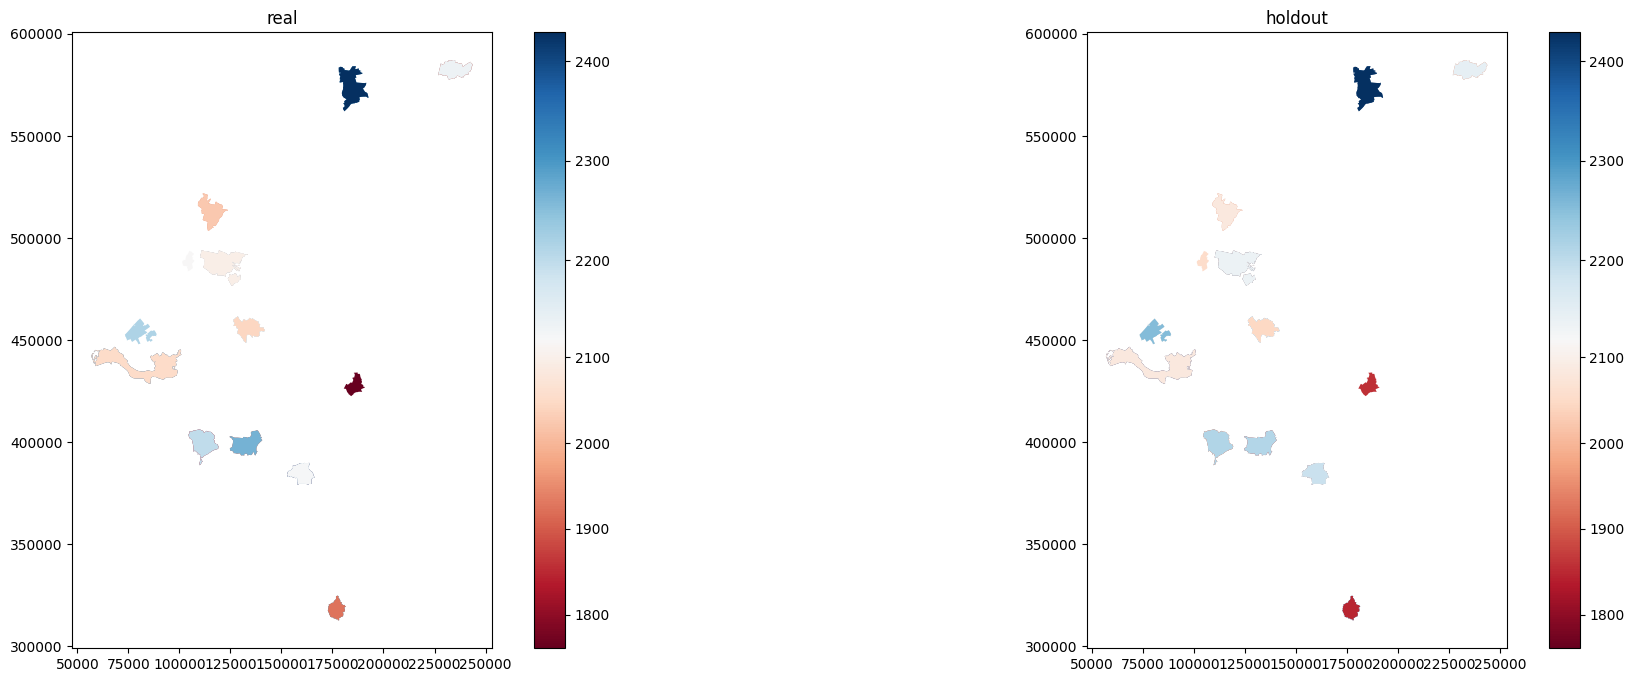

In [33]:
plots[0]

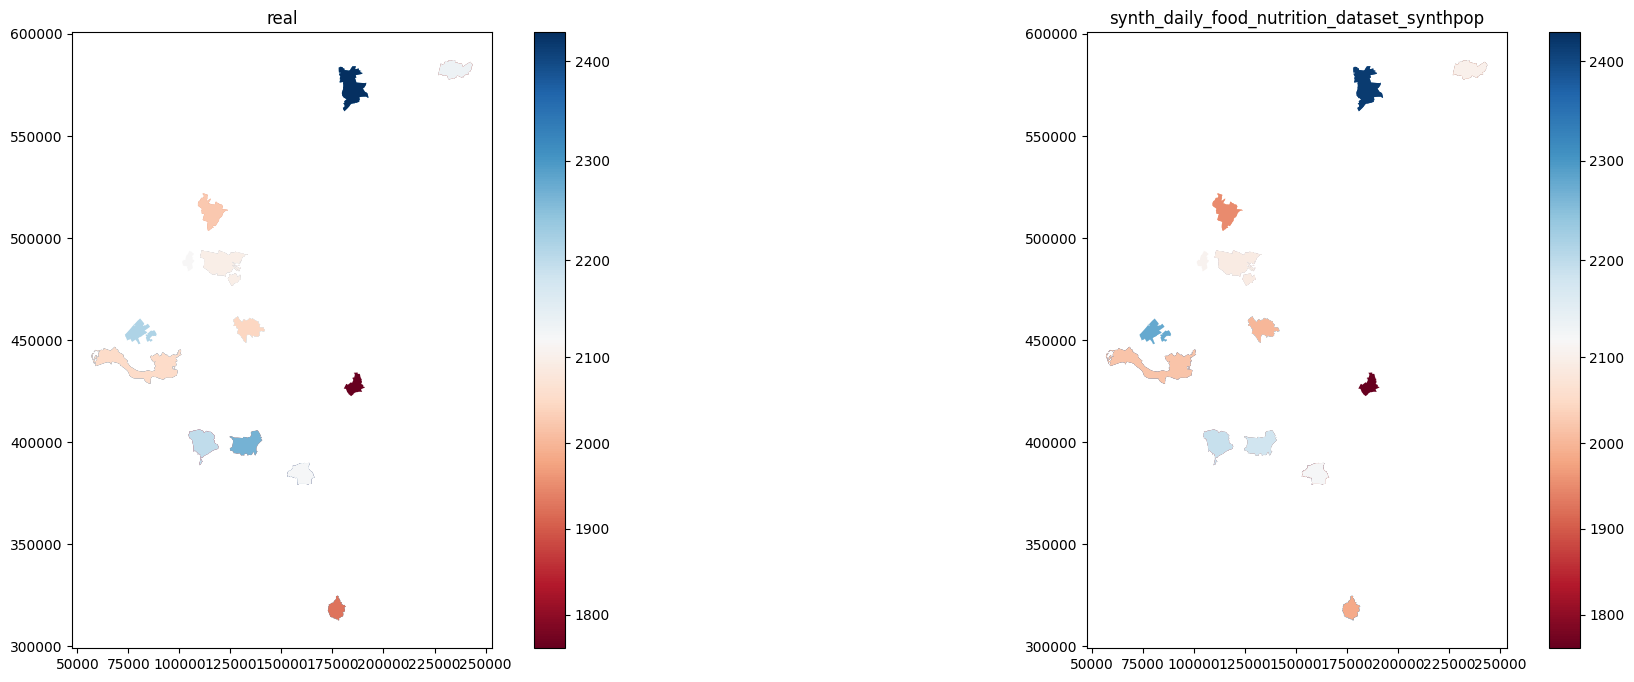

In [34]:
plots[3]

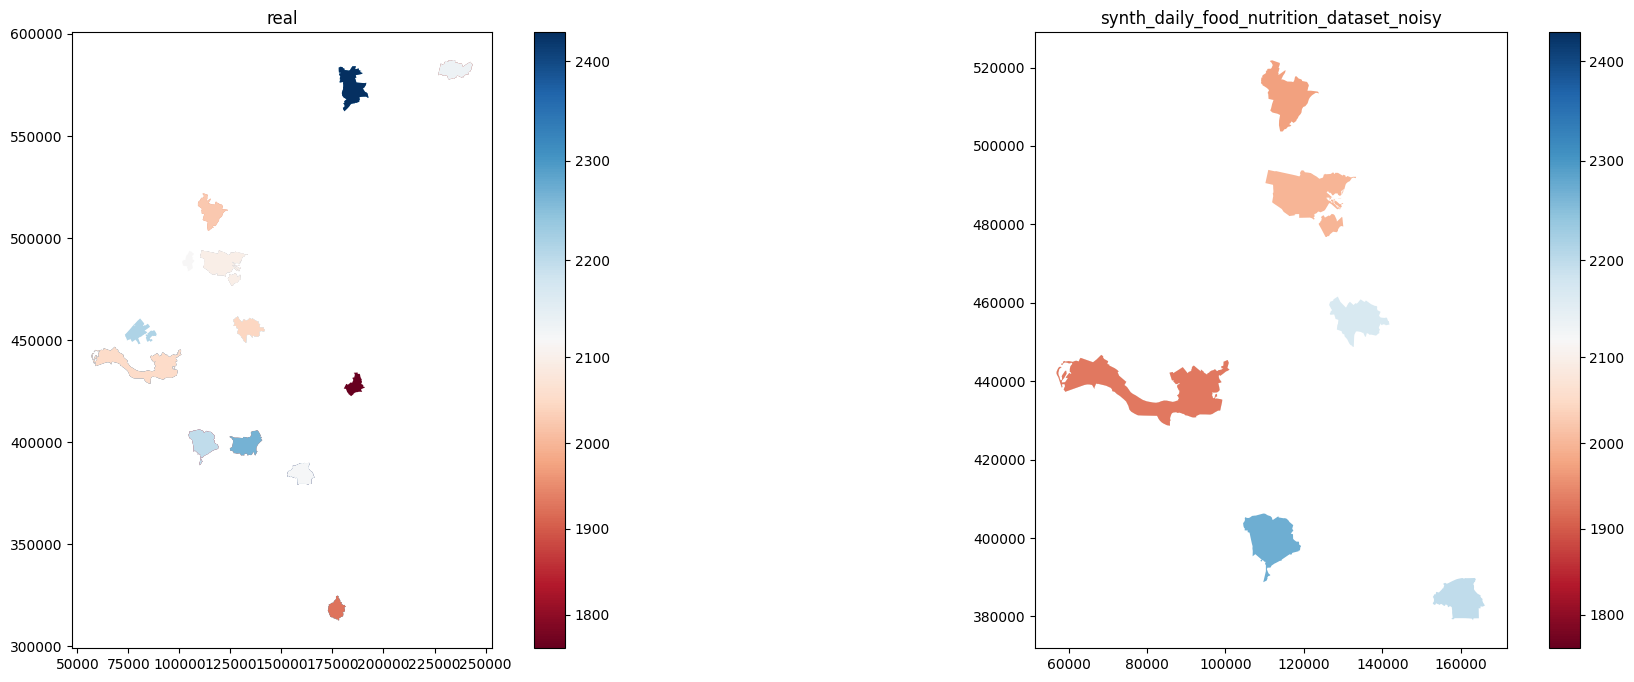

In [35]:
plots[2]

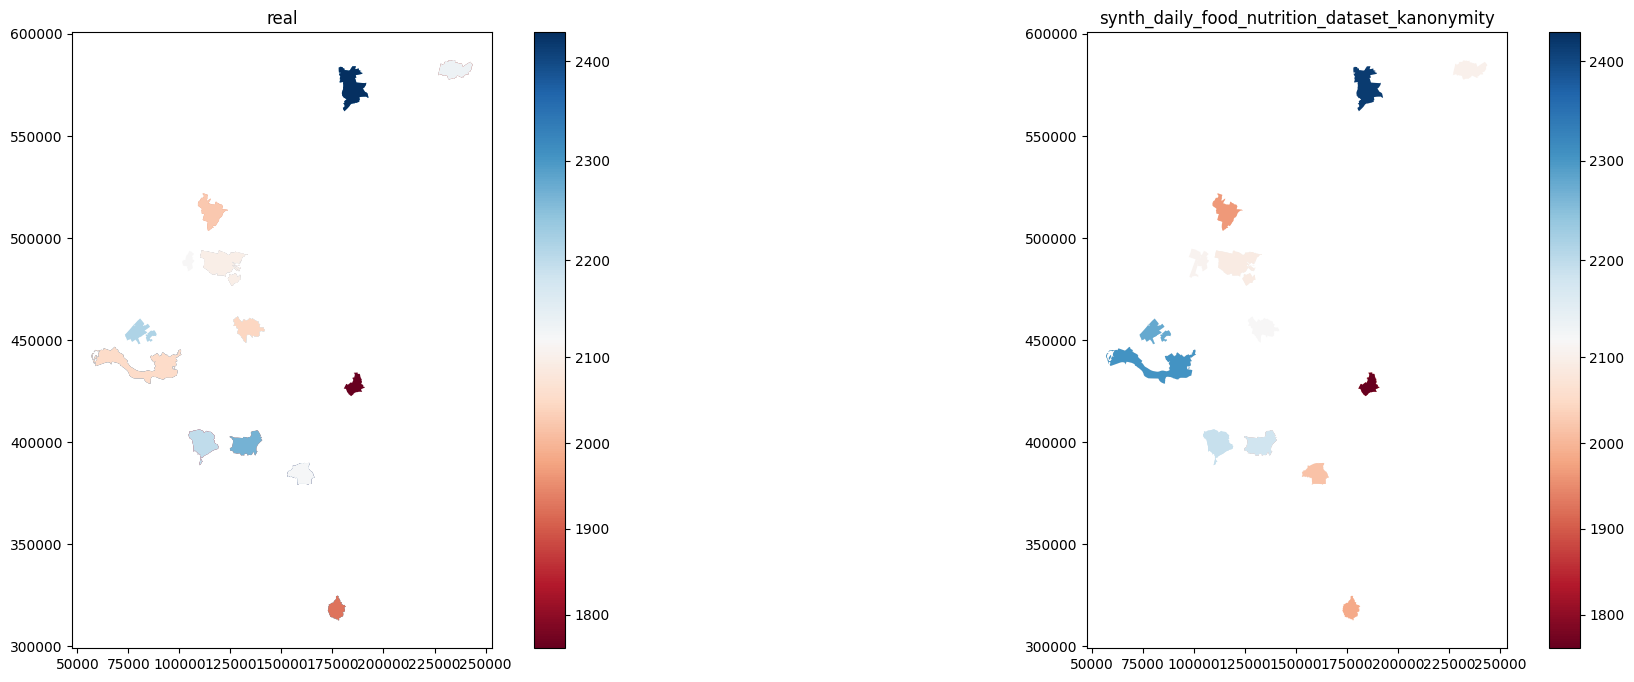

In [36]:
plots[1]

### 5.4.2 Univariate distribution plots

In [37]:
print(df_real[col].min(), df_real[col].max(), df_real[col].nunique())

1200 3125 1070


In [38]:
# This variable could be changed.
# If there are to many bars in the distribution increasing the split nr will benefit this.
# With binary columns change it to 0.5
split = 6

# Change this to one of the columns to alter the graphs.
col = col

In [39]:
dist  = []
for frame in synth_frame:
    df = pd.read_csv(synth_frame[frame])
    df.columns = df_real.columns 
    dist.append(distribution_comparison(df_real, df, column=col, step_split=split, name=frame))

1200 3125 1070
1200 3125 1070
1200 3125 1070
1200 3125 1070


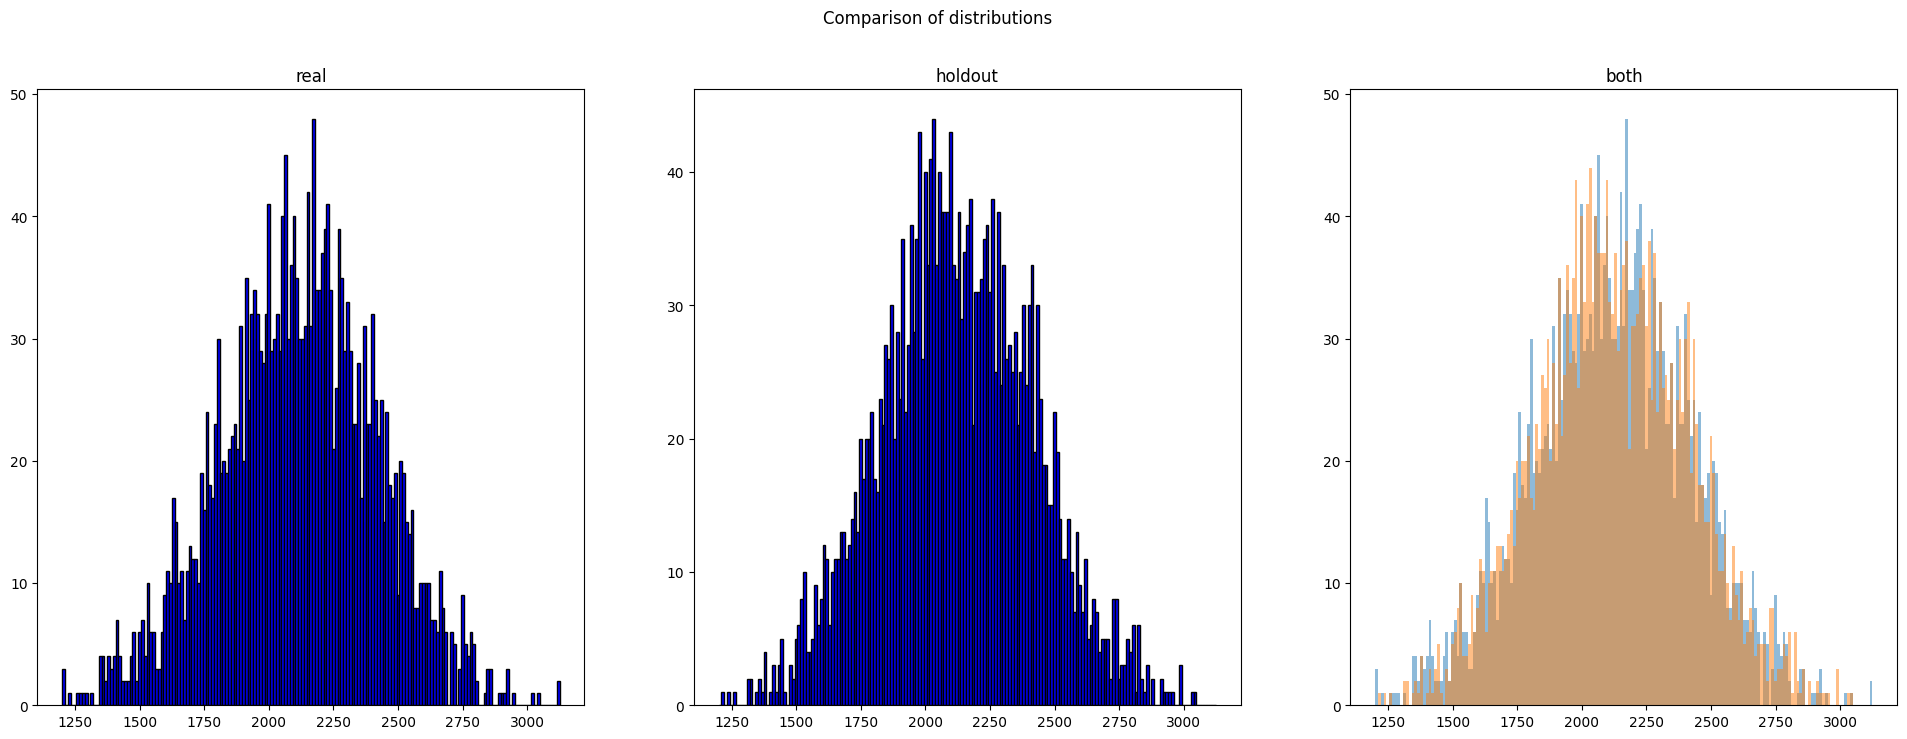

In [40]:
dist[0]

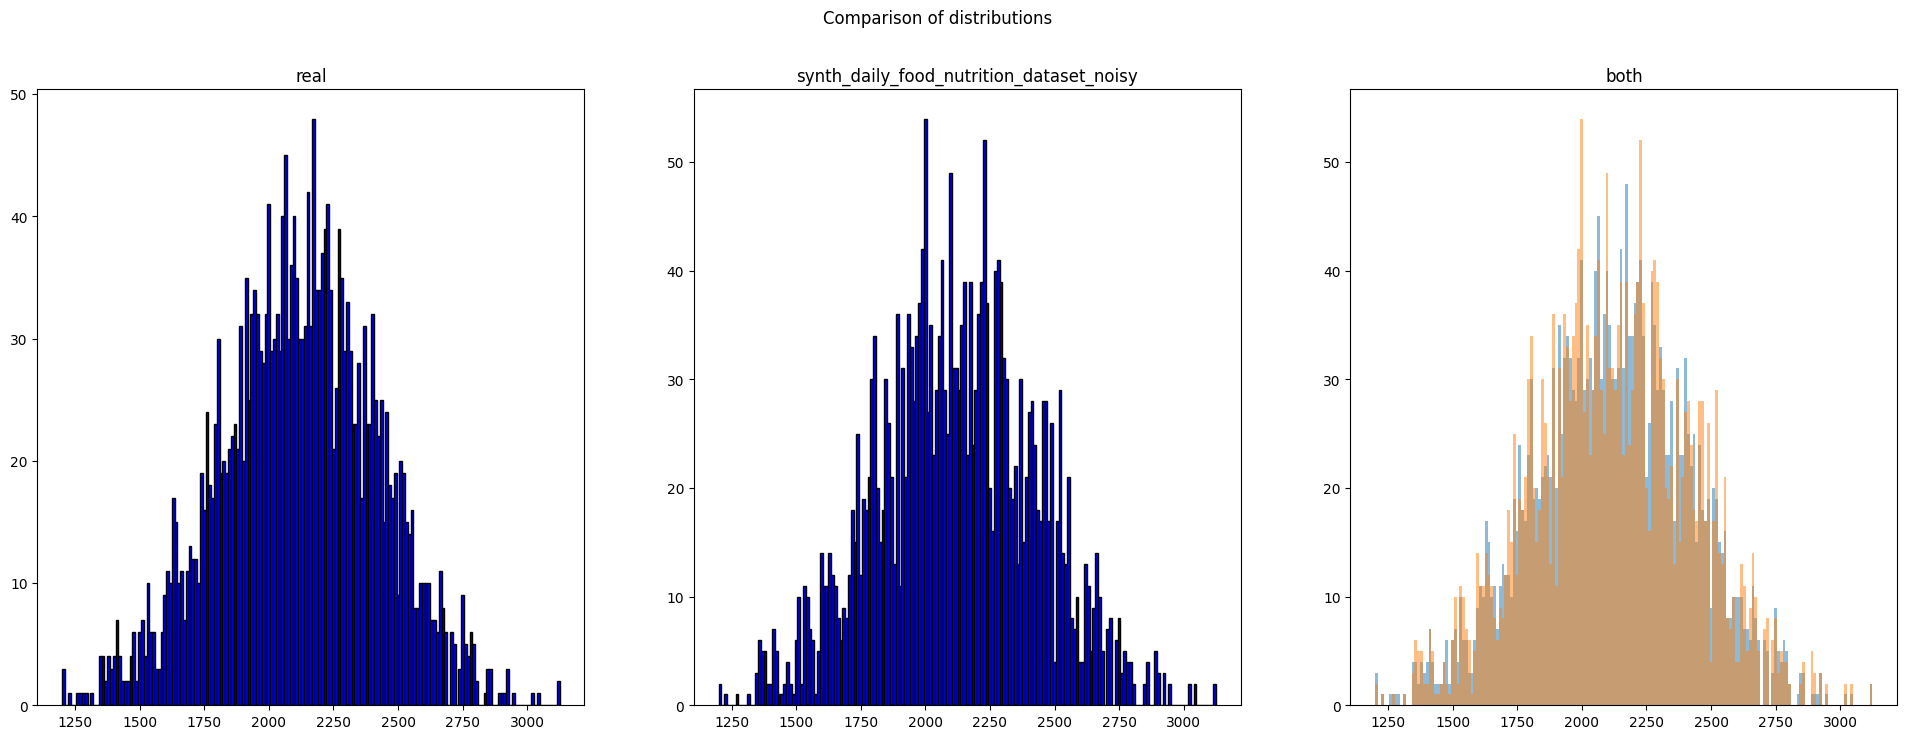

In [41]:
dist[2]

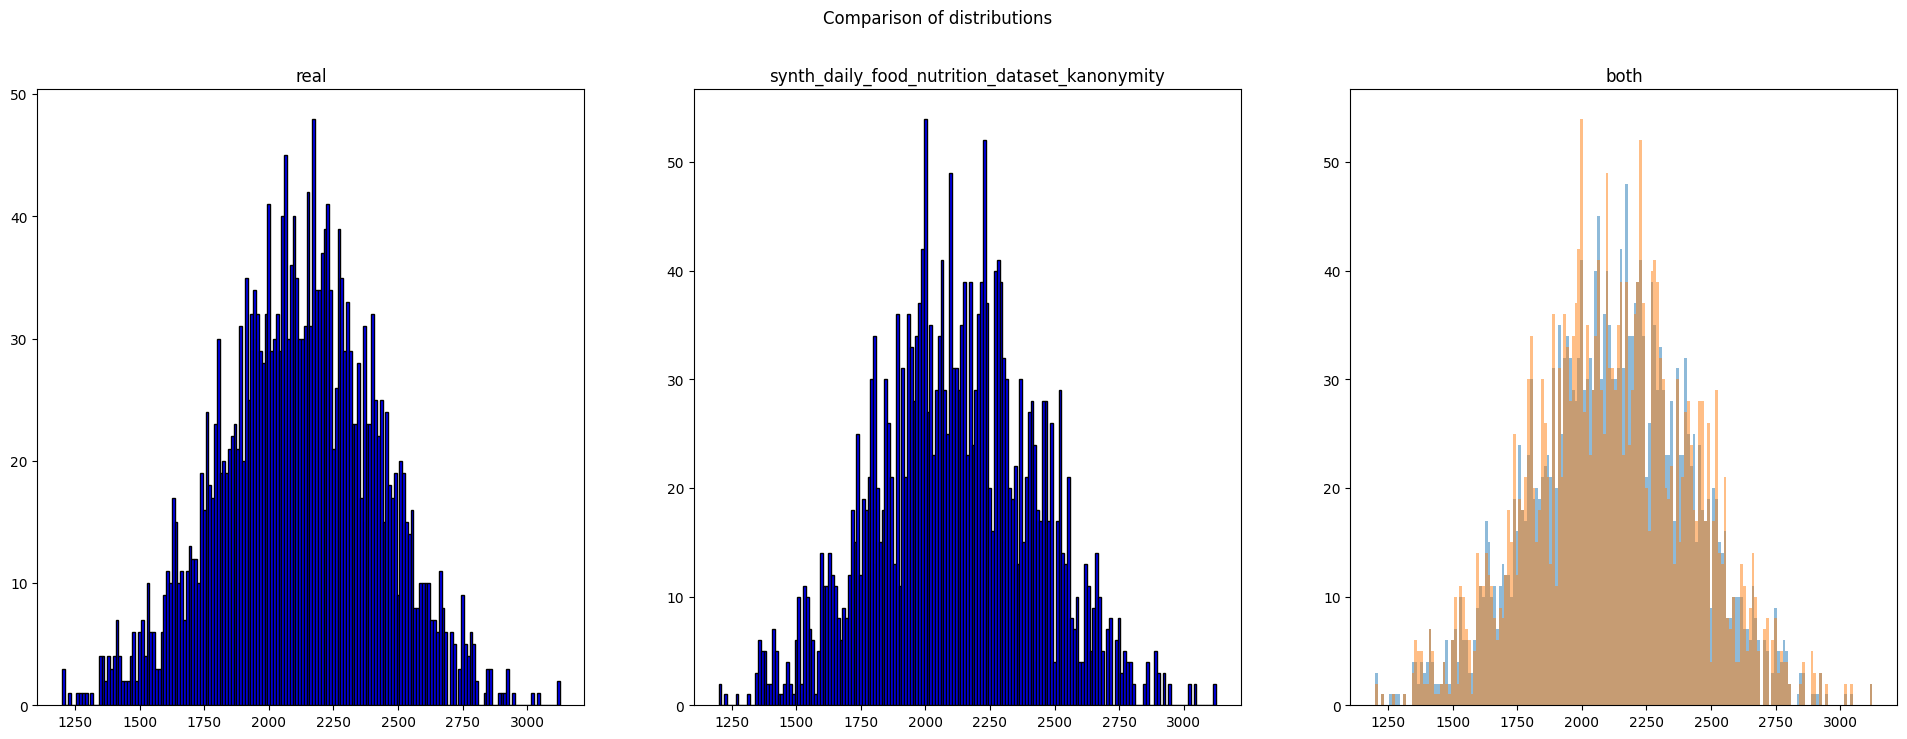

In [42]:
dist[1]